In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [486]:
d = pd.read_csv('../data_real/eeg_zhanna.csv')
words = pd.read_csv('../data_real/words_zhanna_labeled.csv')


In [487]:
lines = open('../data_real/eeg_zhanna_channels.txt').readlines()
lines = lines[1:]
lines = [line.strip() for line in lines]

CHANNELS = dict()
for line in lines:
    num, _, label = line.partition(' ')
    num = int(num) - 1
    CHANNELS[num] = label

In [422]:
d.shape

(78869, 10)

In [390]:
d.head()

,channel_0,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,time,tag
0,5122340,2326871,4909532,1909612,3610901,4706622,2950398,5006381,1.468798e+09,0
1,5151211,2352586,4932233,1920437,3636382,4748018,2968450,5002527,1.468798e+09,0
2,5166898,2373883,4944399,1914734,3646449,4724236,2947837,4990509,1.468798e+09,0
3,5132878,2344088,4918182,1903538,3617601,4680006,2929766,4996053,1.468798e+09,0
4,5120674,2326748,4908352,1909366,3609871,4700974,2947493,5006759,1.468798e+09,0


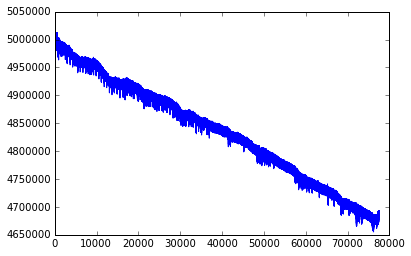

In [391]:
plt.plot(d.channel_7[:77500])

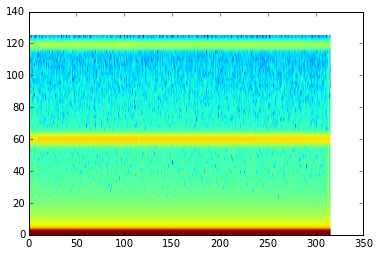

In [392]:
_ = plt.specgram(d.channel_0, NFFT=128, Fs=250, noverlap=64)

In [393]:
eeg = np.array(d.ix[:, 0:8])
eeg = eeg[250:77500,]

tag = np.array(d.ix[:, 'tag'])
tag = tag[250:]

In [394]:
from scipy import signal

In [395]:
# filter from 5 to 35 Hz, helps remove 60Hz noise and replicates paper
## also helps remove the DC line noise (baseline drift)
## 125 is half the sampling rate (250Hz/2)
b, a = signal.butter(4, (2.0/125, 35.0/125), btype='bandpass') 
b, a

(array([ 0.01222321,  0.        , -0.04889285,  0.        ,  0.07333928,
         0.        , -0.04889285,  0.        ,  0.01222321]),
 array([  1.        ,  -5.71974179,  14.41372236, -21.04755049,
         19.59013879, -11.93007722,   4.63594027,  -1.04851038,   0.10608002]))

In [396]:
eeg_f = signal.lfilter(b, a, eeg, axis=0)

In [397]:
## the filter needs a couple samples to converge
## honestly 500 is very conservative, but we don't these samples anyway so whatever
eeg_f = eeg_f[500:]
tag = tag[500:]

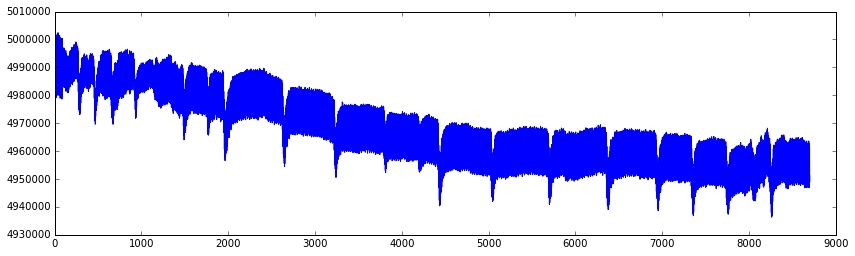

In [398]:
plt.figure(figsize=(14, 4))
plt.plot(eeg[800:9500, 7]) ## raw data

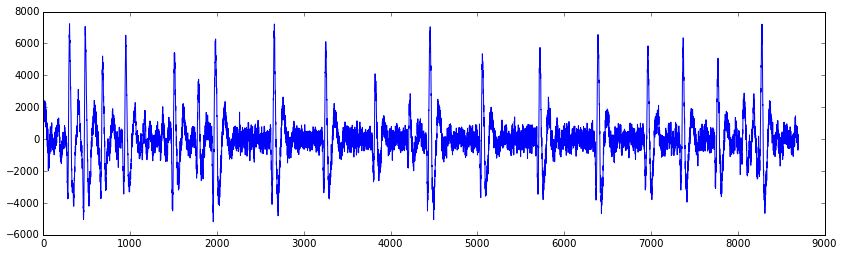

In [399]:
plt.figure(figsize=(14, 4))
plt.plot(eeg_f[300:9000, 7])

In [400]:
from sklearn.decomposition import FastICA

In [401]:
ica = FastICA()
sources = ica.fit_transform(eeg_f)
means = ica.mean_.copy()
mixing = ica.mixing_.copy()

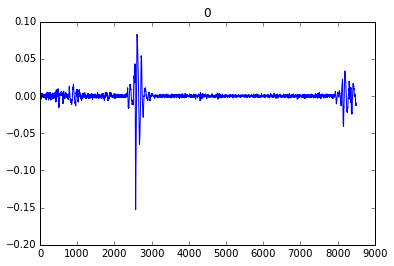

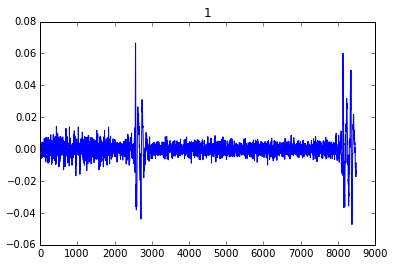

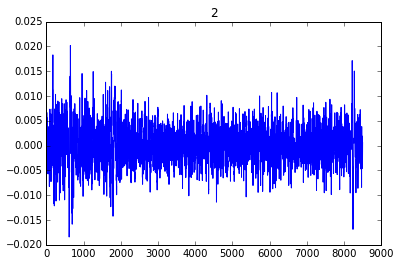

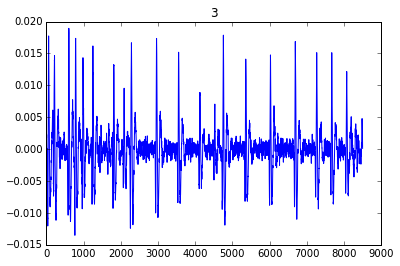

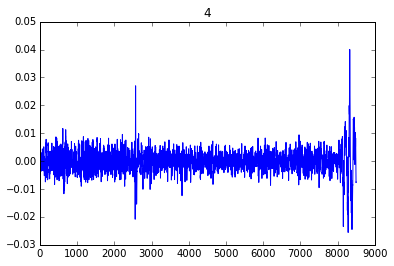

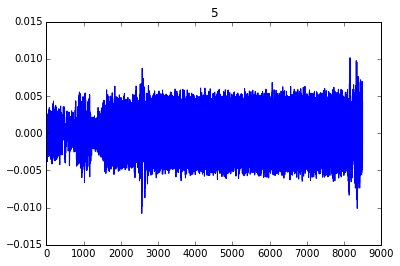

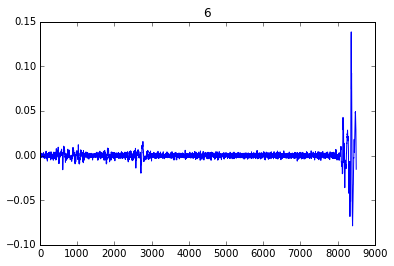

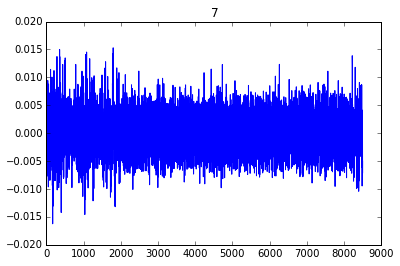

In [402]:
## look at the plots to find the eyeblink component
## TODO: make a more robust eyeblink component finder
for i in range(ica.components_.shape[0]):
    plt.figure()
    plt.plot(sources[:8500, i])
    plt.title(i)

In [408]:
eye_blinks_ix = 3

In [409]:
mixing[:, eye_blinks_ix] = 0 # setting eyeblink component to 0
eeg_ff = sources.dot(mixing.T) + means # this is the ICA inverse transform


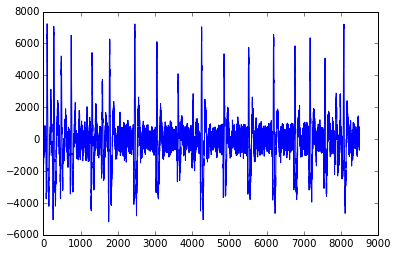

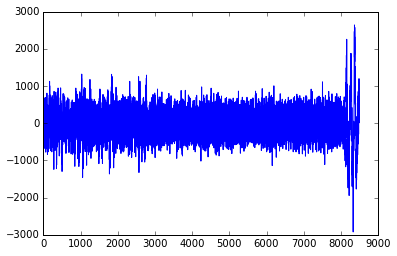

In [410]:
plt.figure()
plt.plot(eeg_f[500:9000, 7])

plt.figure()
plt.plot(eeg_ff[:8500, 7])

In [425]:
word_dict = {}
for i in xrange(words.shape[0]):
    d = dict(words.ix[i])
    word_dict[d['word']] = d

In [433]:
word_starts = []
prev_t = None

for i, t in enumerate(tag):
    if t != 'focus' and t != '0' and t != prev_t:
        w = word_dict[t]
        word_starts.append( {'index': i, 
                             'word': t,
                             'dict': w} )
    prev_t = t

In [434]:
## this confirms that there's ~2.5 seconds between words
np.diff([x['index'] for x in word_starts]) / 250.0

array([ 2.512,  2.512,  2.512,  2.512,  2.512,  2.512,  2.508,  2.512,
        2.512,  2.512,  2.512,  2.512,  2.512,  2.508,  2.512,  2.512,
        2.512,  2.512,  2.512,  2.508,  2.512,  2.512,  2.512,  2.512,
        2.508,  2.512,  2.512,  2.512,  2.512,  2.508,  2.512,  2.512,
        2.512,  2.508,  2.512,  2.512,  2.512,  2.508,  2.512,  2.512,
        2.512,  2.508,  2.512,  2.512,  2.512,  2.512,  2.512,  2.512,
        2.512,  2.508,  2.512,  2.512,  2.512,  2.508,  2.516,  2.508,
        2.516,  2.508,  2.512,  2.512,  2.508,  2.516,  2.512,  2.512,
        2.512,  2.508,  2.512,  2.512,  2.512,  2.512,  2.512,  2.512,
        2.512,  2.508,  2.512,  2.512,  2.508,  2.512,  2.512,  2.512,
        2.512,  2.512,  2.508,  2.512,  2.512,  2.508,  2.512,  2.512,
        2.508,  2.512,  2.516,  2.508,  2.512,  2.512,  2.508,  2.512,
        2.512,  2.512,  2.512,  2.512,  2.508,  2.512,  2.512,  2.512,
        2.512,  2.512,  2.512,  2.508,  2.512,  2.512,  2.512,  2.508,
      

In [495]:
recognized = np.array([w['dict']['recognized'] for w in word_starts])

In [496]:
eeg_trials = np.zeros((8, len(word_starts), int(250*2.5)))
time = np.arange(0, eeg_trials.shape[2], 1) / 250.0 - 0.5

In [497]:
for c in range(8):
    for i in range(len(word_starts)):
        d = word_starts[i]
        start = d['index']
        # 125 samples = 0.5s, 500 samples = 2.0 s
        # we want 0.5s before the stimulus presentation and 2.0 seconds after
        eeg_trials[c, i, :] = eeg_ff[start-125:start+500, c] 

In [506]:
# for c in range(8):
#     plt.figure(figsize=(14, 4))
#     _ = plt.plot(time, np.mean(eeg_trials[c], axis=0))
#    plt.title(CHANNELS[c])

In [512]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


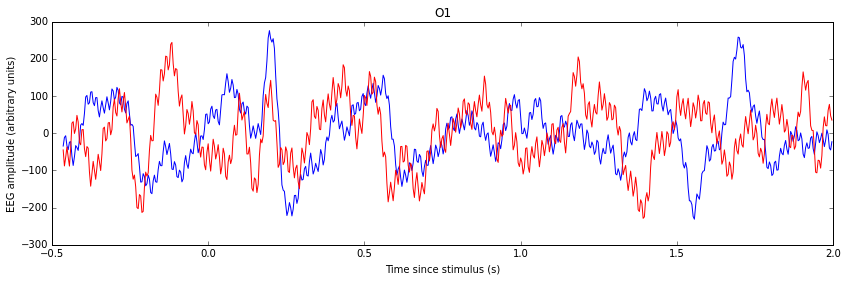

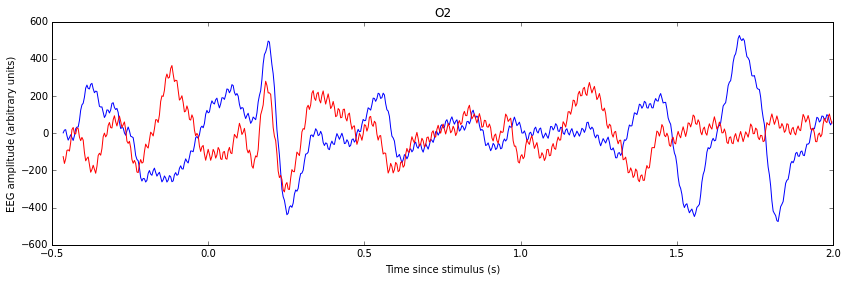

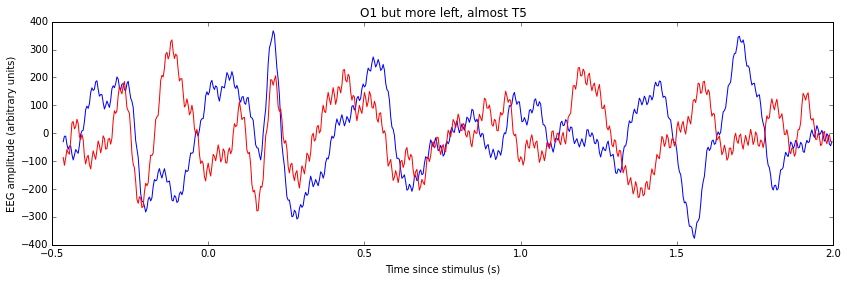

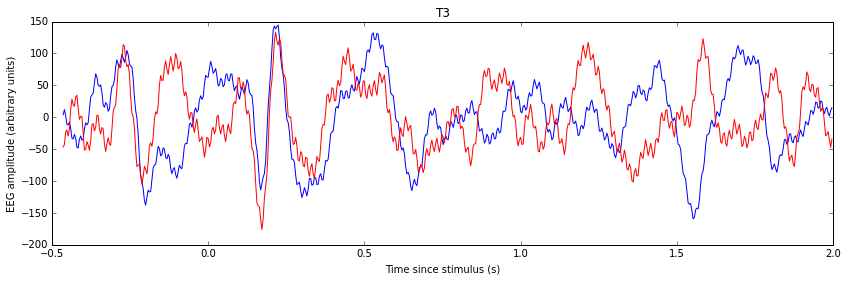

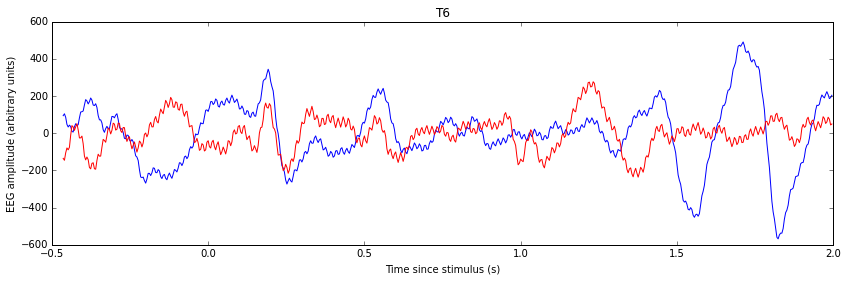

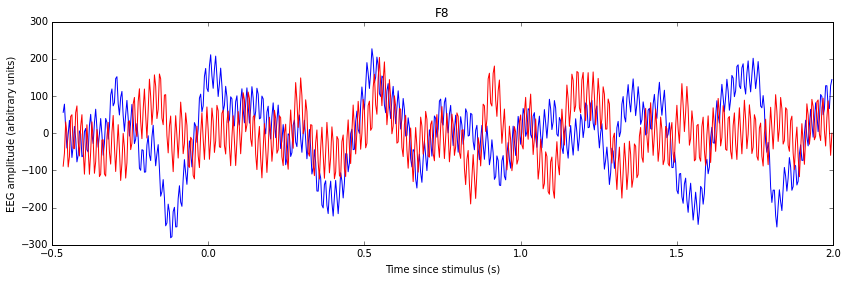

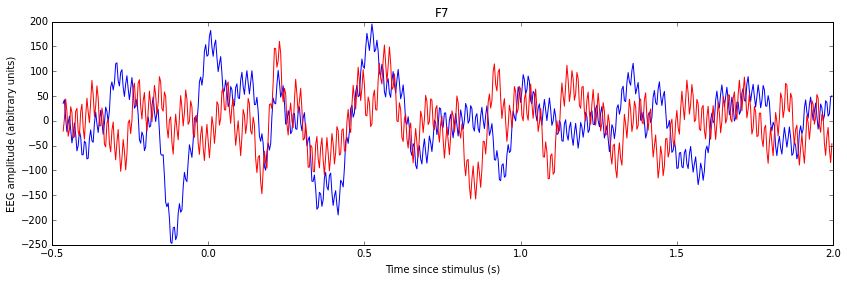

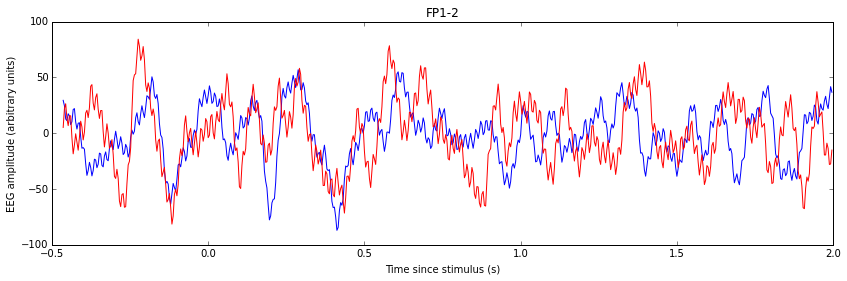

In [525]:
## this shows the ERPs for -0.5s to 2.5s with 0s = when stimulus is shown
## blue is for remembered words
## red is for not remembered words

N_AVG = 10

for i in range(8):
    plt.figure(figsize=(14, 4))
    
    rec = np.mean(eeg_trials[i][recognized], axis=0)
    rec = moving_average(rec, n=N_AVG)
    _ = plt.plot(time[(N_AVG-1):], rec, c='blue')
    
    not_rec = np.mean(eeg_trials[i][~recognized], axis=0)
    not_rec = moving_average(not_rec, n=N_AVG)
    _ = plt.plot(time[(N_AVG-1):], not_rec, c='red')
    plt.title(CHANNELS[i])
    
    plt.xlabel('Time since stimulus (s)')
    plt.ylabel('EEG amplitude (arbitrary units)')

## 